# Convolutional neural networks (CNNs) for the diagnosis of oral cancer

_by Phil Harrison (February 2021)_

### Overview
In this lab you'll learn how to implement your own convolutional neural networks (CNNs) for classifying human oral cells as either 'healthy' or 'tumor'.

### Dataset
We will be using a simplified subset of the data analysed in the paper "Deep Convolutional Neural Networks For Detecting Cellular Changes Due To
Malignancy" by Wieslander et al. (2017) (http://openaccess.thecvf.com/content_ICCV_2017_workshops/papers/w1/Wieslander_Deep_Convolutional_Neural_ICCV_2017_paper.pdf). The CNNs we'll be training in this lab will be more basic than those used in that paper.

A quote from Weislander et al. regarding the dataset: 

"_The cell samples were collected at Södersjukhuset in Stockholm. The patients have mixed genders, are non smoking, some are human papillomavirus (HPV) positive and some are not, and they have an age span of 47-77 years. From each patient samples were collected with a brush that is scraped at areas of interest in the oral cavity. Each scrape is then smeared out on a glass, which is then stained to highlight important cellular structures_".

<p>
    <img src="figs/oral_cancer_summary.png" alt="drawing"  style="width:800px;"/>
    <center>Figure 1. Oral cancer data summary.</center>
</p>

Example cell images Weislander et al. used are shown below. These images were greyscale and 80 x 80 pixels.

<p>
    <img src="figs/cancer_cells.png" alt="drawing" style="width:800px;"/>
    <center>Figure 2. Example oral cancer cell images.</center>
</p>

To simplify the data for the lab I took smaller crops of 48 x 48 pixels around each cell and only took a subsample of the entire dataset. All the images were then shuffled and allocated to the training, validation or test set. Hence, here we are solving a simpler classification task than the more robust one carried out by Weislander et al. where the data were not shuffled and cells from a given patient could only be in one of the three sets. A more robust and generalizable approach would be to do what Weislander et al. did, so keep this in mind.

### Note
Some of the code cells below are kind of boiler plate code, for getting things in the right format, plotting various things and what not. This might be of interest for some of you that want to take these things further and use them on other datasets, for others they will just be distracting. Don't get too distracted. The main parts are those code cells where I ask you to modify things. Either way, you need to run these code cells for the other parts to run properly...

Also below we use `generators` to load the data from directories in small batches. This is useful if your dataset is bigger than fits into the GPU memory. GPUs are super fast for fitting neural networks, much faster than CPUs, although they have less memory space than CPUs. Don't worry too much about these generators. I put them here that you can refer back to this code, should any of you decide to take deep learning further, such as if you decide to do your thesis project in this area. This is the only place we will work with them. The data for the assignment tomorrow is small enough that it fits onto memory and we won't be needing them there...

## Load packages
Somewhat more packages than we loaded before. Nothing to worry about.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import pandas as pd
import cv2
import re
import glob
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from datetime import datetime

from tifffile import imread

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
print(tf.__version__)

2.1.0


## Plotting and summarising functions
Don't worry too much about the code in the functions below, but you might want to go through when they are called later on so that you roughly understand what they're doing.

In [2]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(20,6), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Training', 'Validation'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy', 
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Training', 'Validation'], loc='upper left')
    plt.show()
    plt.close()

def plot_confusion_matrix(cm, classes, model_name,
                          cmap=plt.cm.Blues):
    title = model_name
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_sample_images():
    # plot 5 healthy cells form training data
    print('random sample of healthy cells from training set')
    print('')
    all_cells = glob.glob(train_healthy_dir + '/' '*')
    n_cells = len(all_cells)
    to_plot = np.random.choice(n_cells, 5, replace=False)

    plt.figure(figsize=(20, 120), facecolor='w')

    for i in range(5):
        im = imread(all_cells[to_plot[i]])
        sub_index = 151 + i
        plt.subplot(sub_index)
        plt.imshow(im[:, :, 0], cmap='gray')
        plt.xticks([])
        plt.yticks([])


    plt.show()
    plt.close()

    # plot 5 tumor cells form training data
    print('')
    print('random sample of tumor cells from training set')
    print('')
    all_cells = glob.glob(train_tumor_dir + '/' '*')
    n_cells = len(all_cells)
    to_plot = np.random.choice(n_cells, 5, replace=False)

    plt.figure(figsize=(20, 120), facecolor='w')

    for i in range(5):
        im = imread(all_cells[to_plot[i]])
        sub_index = 151 + i
        plt.subplot(sub_index)
        plt.imshow(im[:, :, 0], cmap='gray')
        plt.xticks([])
        plt.yticks([])


    plt.show()
    plt.close()

def data_summary():
    print('no. training healthy images:', len(os.listdir(train_healthy_dir)))
    print('no. training tumor images:', len(os.listdir(train_tumor_dir)))
    print('')
    print('no. validation healthy images:', len(os.listdir(validation_healthy_dir)))
    print('no. validation tumor images:', len(os.listdir(validation_tumor_dir)))
    print('')
    print('no. test healthy images:', len(os.listdir(test_healthy_dir)))
    print('no. test tumor images:', len(os.listdir(test_tumor_dir)))

## Specify data directories
Run the cell below to define the directories where our image data has been placed.

In [3]:
# directory we will store our dataset
base_dir = 'HPV/data_v3'

# directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# directory with our training healthy cell images
train_healthy_dir = os.path.join(train_dir, 'healthy')

# directory with our training tumor cell images
train_tumor_dir = os.path.join(train_dir, 'tumor')

# directory with our validation healthy cell images
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# directory with our validation tumor cell images
validation_tumor_dir = os.path.join(validation_dir, 'tumor')

# directory with our test healthy cell images
test_healthy_dir = os.path.join(test_dir, 'healthy')

# directory with our test tumor cell images
test_tumor_dir = os.path.join(test_dir, 'tumor')

## Data summary
Run the code cell below to get a summary of the data.

In [4]:
data_summary()

no. training healthy images: 1281
no. training tumor images: 784

no. validation healthy images: 316
no. validation tumor images: 198

no. test healthy images: 401
no. test tumor images: 243


## Sample images
Run the jupyter cell below to see a sample of the 48 x 48 greyscale images
(you can run this multiple times to get different samples and to think about what the differences between the healthy and cancer cells might be).

random sample of healthy cells from training set



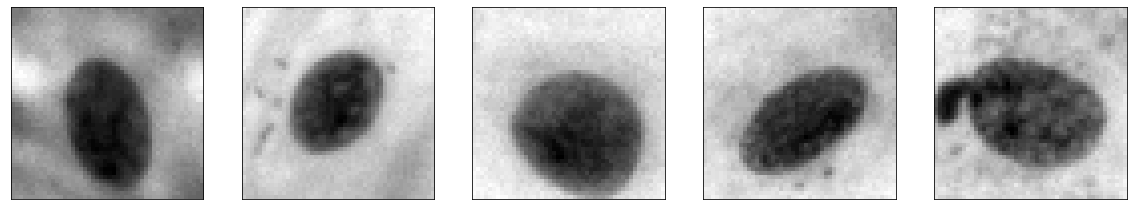


random sample of tumor cells from training set



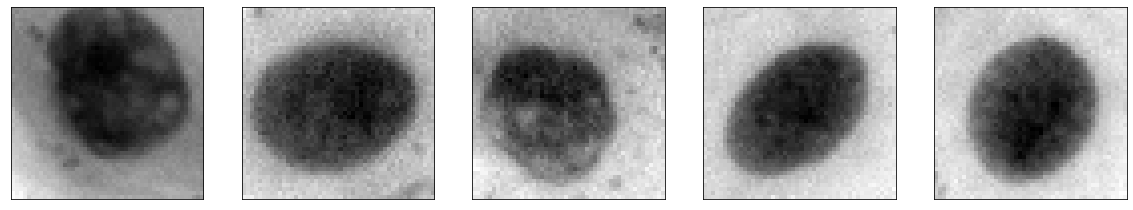

In [5]:
plot_sample_images()

## Basic convolutional neural network (CNN)

Convolutional Neural Networks (CNNs) use convolutions instead of the normal fully connected layers, which have proven to be highly successful for image recognition tasks. By convolving filters on the input layer and outputting the results to the next layer, the CNN "detects" (or learns) features at different levels of abstraction throughout the network. With lower-level abstractions (like edges and blobs) in the early layers, and higher-level abstractions (like cells) in deeper layers. The figure below shows the LeNet inspired CNN that we will shortly be implementing.

<p>
    <img src="figs/CNN.png" alt="drawing" style="width:1200px;"/>
</p>

## Some additional bits and pieces

In [6]:
x_len = 48
y_len = 48
batch_size = 32
n_epochs = 50

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print('TRAINING DATA:')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')

print('')
print('VALIDATION DATA:')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False)

print('')
print('TEST DATA:')
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False)

train_steps = (len(os.listdir(train_healthy_dir)) + len(os.listdir(train_tumor_dir))) // batch_size
validation_steps = (len(os.listdir(validation_healthy_dir)) + len(os.listdir(validation_tumor_dir))) // batch_size
test_steps = (len(os.listdir(test_healthy_dir)) + len(os.listdir(test_tumor_dir))) // batch_size
    
def valid_evaluate(model):
    y_pred = model.predict_generator(validation_generator, validation_steps+1)
    y_pred = y_pred > 0.5
    y_true = validation_generator.classes
    class_names = ['healthy', 'tumor']
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name='confusion matrix for validation data')
    plt.show()
    plt.close()
    
    print('')
    print('classification report for validation data:')
    print(classification_report(y_true, y_pred, digits=3))

def test_evaluate(model):
    y_pred = model.predict_generator(test_generator, test_steps+1)
    y_pred = y_pred > 0.5
    y_true = test_generator.classes
    class_names = ['healthy', 'tumor']
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(15,5), facecolor='w')
    plot_confusion_matrix(cnf_matrix, classes=class_names, model_name='confusion matrix for test data')
    plt.show()
    plt.close()
    
    print('')
    print('classification report for test data:')
    print(classification_report(y_true, y_pred, digits=3))

TRAINING DATA:
Found 2065 images belonging to 2 classes.

VALIDATION DATA:
Found 514 images belonging to 2 classes.

TEST DATA:
Found 644 images belonging to 2 classes.


## First pass CNN

### Define and summarise the model

In [7]:
inps = layers.Input((x_len, y_len, 1)) # input image dimensions

# convolution and pooling layers
x = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(inps)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(1, activation='sigmoid')(x)

CNN1 = models.Model(inputs=inps, outputs=preds)
CNN1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                294976

### Compile the model

In [8]:
CNN1.compile(loss='binary_crossentropy',
            optimizer=optimizers.Adam(lr=0.001),
            metrics=['accuracy'])

## Fit and evaluate the model
Note: When you run the cell below you will probably get a WARNING message about sample_weight modes. This is a small bug in the version of TesorFlow we are using and has been fixed in more recent versions. You can safely ignore this warning message, it doesn't affect anything.

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 64 steps, validate for 16 steps
Epoch 1/50
64/64 - 3s - loss: 0.6763 - acc: 0.6134 - val_loss: 0.6683 - val_acc: 0.6172
Epoch 2/50
64/64 - 3s - loss: 0.6671 - acc: 0.6212 - val_loss: 0.6883 - val_acc: 0.6172
Epoch 3/50
64/64 - 3s - loss: 0.6658 - acc: 0.6163 - val_loss: 0.6534 - val_acc: 0.6172
Epoch 4/50
64/64 - 2s - loss: 0.6270 - acc: 0.6262 - val_loss: 0.5894 - val_acc: 0.6895
Epoch 5/50
64/64 - 3s - loss: 0.5807 - acc: 0.7024 - val_loss: 0.5617 - val_acc: 0.7227
Epoch 6/50
64/64 - 3s - loss: 0.5522 - acc: 0.7191 - val_loss: 0.5502 - val_acc: 0.7344
Epoch 7/50
64/64 - 2s - loss: 0.5597 - acc: 0.6990 - val_loss: 0.5733 - val_acc: 0.7305
Epoch 8/50
64/64 - 3s - loss: 0.5539 - acc: 0.7275 - val_loss: 0.5576 - val_acc: 0.7461
Epoch 9/50
64/64 - 2s - loss: 0.5428 - acc: 0.7344 - val_loss: 0.5578 - val_acc: 0.7227
Epoch 10/50
64/64 - 3s - loss: 0.5369 - acc: 0.7354 - val_loss: 0.5411 - val_acc: 0.7598
Epoch 11/50
64/64 - 2s - lo

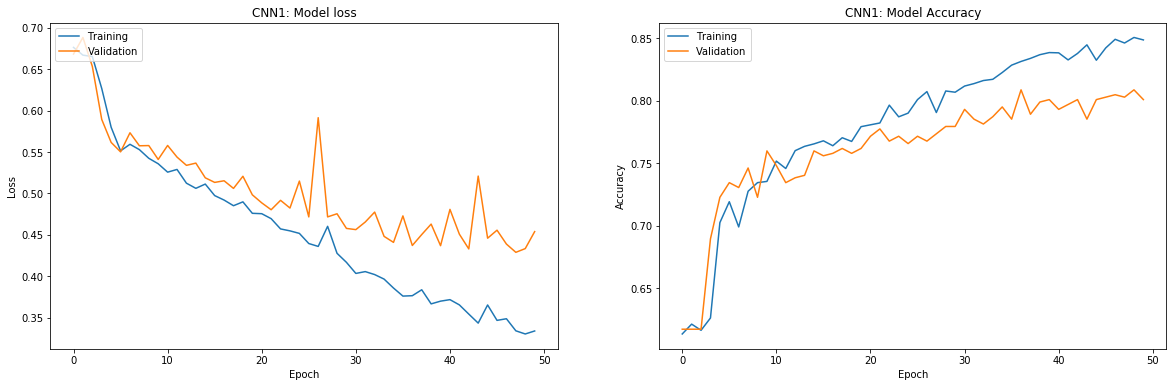

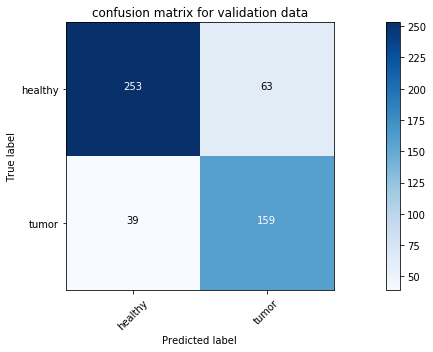


classification report for validation data:
              precision    recall  f1-score   support

           0      0.866     0.801     0.832       316
           1      0.716     0.803     0.757       198

    accuracy                          0.802       514
   macro avg      0.791     0.802     0.795       514
weighted avg      0.809     0.802     0.803       514



In [9]:
history = CNN1.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2)

plot_history(history, 'CNN1')

valid_evaluate(CNN1)

## Alternative model architectures
In the code cells below try some alternative model architectures. Use the 'weighted avg f1-score' on the validation data to compare different model architectures and to decide which one was best.

* try fitting different models with different numbers of convolutional layers (you can have between two and five for this data, more than five convolutional layers does not work for this data due to the shrinking of the spatial dimensions of the filter maps as they go through max pooling)
* you can also play around with the number of filters for each convolutional layer
* and you can experiment with different values for the dropout rate, or with no dropout at all (by either setting the dropout rate to 0.0 or removing the dropout code line all together)
* finally, you are free to explore different numbers of neurons for the final dense layer (just before our prediction (preds) layer).

#### Notes: 
* if your model does not seem to have converged after 25 epochs (the default value) you can also raise the number of epochs to train for.
* name your model CNN2, CNN3 etc.

In [10]:
inps = layers.Input((x_len, y_len, 1)) # input image dimensions

# convolution and pooling layers
x = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(inps)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(1, activation='sigmoid')(x)

CNN2 = models.Model(inputs=inps, outputs=preds)
CNN2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0   

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 64 steps, validate for 16 steps
Epoch 1/50
64/64 - 4s - loss: 0.6704 - acc: 0.6203 - val_loss: 0.6652 - val_acc: 0.6172
Epoch 2/50
64/64 - 3s - loss: 0.6462 - acc: 0.6188 - val_loss: 0.6085 - val_acc: 0.6172
Epoch 3/50
64/64 - 3s - loss: 0.5523 - acc: 0.7211 - val_loss: 0.5653 - val_acc: 0.7461
Epoch 4/50
64/64 - 3s - loss: 0.5278 - acc: 0.7462 - val_loss: 0.5582 - val_acc: 0.7070
Epoch 5/50
64/64 - 3s - loss: 0.5293 - acc: 0.7664 - val_loss: 0.5611 - val_acc: 0.7051
Epoch 6/50
64/64 - 3s - loss: 0.5167 - acc: 0.7664 - val_loss: 0.5275 - val_acc: 0.7383
Epoch 7/50
64/64 - 3s - loss: 0.4940 - acc: 0.7629 - val_loss: 0.5134 - val_acc: 0.7617
Epoch 8/50
64/64 - 3s - loss: 0.4810 - acc: 0.7860 - val_loss: 0.5019 - val_acc: 0.7734
Epoch 9/50
64/64 - 3s - loss: 0.4624 - acc: 0.7890 - val_loss: 0.5126 - val_acc: 0.7773
Epoch 10/50
64/64 - 3s - loss: 0.4601 - acc: 0.7983 - val_loss: 0.4896 - val_acc: 0.7969
Epoch 11/50
64/64 - 3s - lo

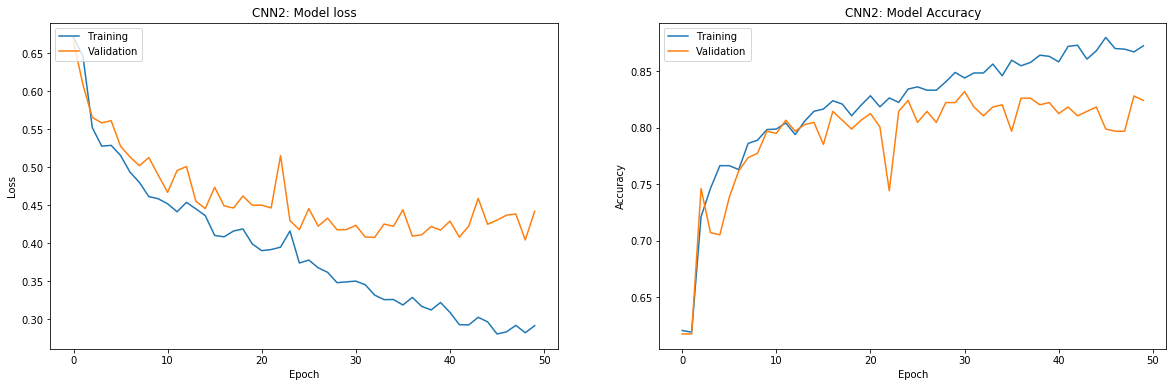

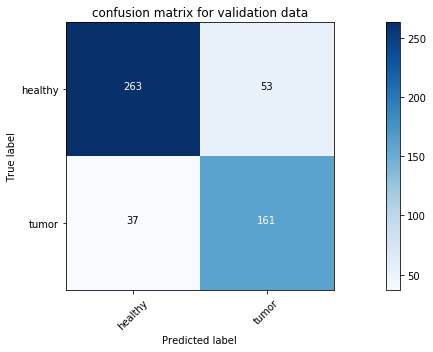


classification report for validation data:
              precision    recall  f1-score   support

           0      0.877     0.832     0.854       316
           1      0.752     0.813     0.782       198

    accuracy                          0.825       514
   macro avg      0.815     0.823     0.818       514
weighted avg      0.829     0.825     0.826       514



In [11]:
CNN2.compile(loss='binary_crossentropy',
            optimizer=optimizers.Adam(lr=0.001),
            metrics=['accuracy'])

history = CNN2.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2)

plot_history(history, 'CNN2')

valid_evaluate(CNN2)

## Adding data augmentation

DATA AUGMENTATION: "_An approach to overcome the challenges posed by a limited amount of annotated training data. Augmentation is performed by artificially generating more annotated training data, typically by mirroring and rotating the original images_".

We will use the same 8x data augmentation as used by Wieslander et al.:

<p>
    <img src="figs/augmentation.png" alt="drawing" style="width:1000px;"/>
</p>

In [12]:
# we add the data augmentations above via training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')

Found 2065 images belonging to 2 classes.


In [13]:
inps = layers.Input((x_len, y_len, 1)) # input image dimensions

# convolution and pooling layers
x = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(inps)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(1, activation='sigmoid')(x)

CNN1_aug = models.Model(inputs=inps, outputs=preds)
CNN1_aug.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2949

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 64 steps, validate for 16 steps
Epoch 1/50
64/64 - 4s - loss: 0.6705 - acc: 0.6149 - val_loss: 0.6594 - val_acc: 0.6172
Epoch 2/50
64/64 - 4s - loss: 0.6493 - acc: 0.6321 - val_loss: 0.6285 - val_acc: 0.7500
Epoch 3/50
64/64 - 4s - loss: 0.6012 - acc: 0.6886 - val_loss: 0.5718 - val_acc: 0.7168
Epoch 4/50
64/64 - 4s - loss: 0.5575 - acc: 0.7196 - val_loss: 0.5528 - val_acc: 0.7441
Epoch 5/50
64/64 - 4s - loss: 0.5631 - acc: 0.7250 - val_loss: 0.5484 - val_acc: 0.7383
Epoch 6/50
64/64 - 4s - loss: 0.5465 - acc: 0.7472 - val_loss: 0.5482 - val_acc: 0.7383
Epoch 7/50
64/64 - 4s - loss: 0.5457 - acc: 0.7467 - val_loss: 0.5344 - val_acc: 0.7520
Epoch 8/50
64/64 - 4s - loss: 0.5406 - acc: 0.7373 - val_loss: 0.5648 - val_acc: 0.7266
Epoch 9/50
64/64 - 4s - loss: 0.5380 - acc: 0.7462 - val_loss: 0.5389 - val_acc: 0.7520
Epoch 10/50
64/64 - 4s - loss: 0.5270 - acc: 0.7550 - val_loss: 0.5193 - val_acc: 0.7598
Epoch 11/50
64/64 - 3s - lo

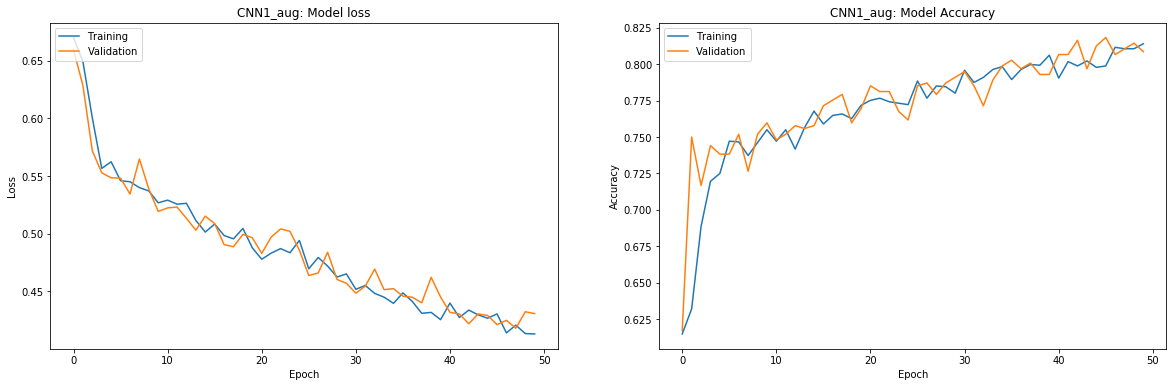

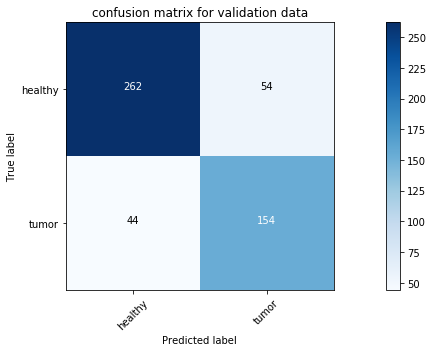


classification report for validation data:
              precision    recall  f1-score   support

           0      0.856     0.829     0.842       316
           1      0.740     0.778     0.759       198

    accuracy                          0.809       514
   macro avg      0.798     0.803     0.801       514
weighted avg      0.812     0.809     0.810       514



In [14]:
CNN1_aug.compile(loss='binary_crossentropy',
                 optimizer=optimizers.Adam(lr=0.001),
                 metrics=['accuracy'])

history = CNN1_aug.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2)

plot_history(history, 'CNN1_aug')

valid_evaluate(CNN1_aug)

## Did data augmentation help?
When I ran these model I got a `weighted avg f1 score` of 0.803 without augmentation (CNN1) and 0.810 with augmentation (CNN1_aug). So perhaps some help here in this case. Note this could have been due to stochasticity in the local minima the two models found (see the `Final note` section at the end of this notebook). Hence for your runs, you may have gotten different results. There are also other (fancier) augmentations that one can try, that can sometimes help, such as shifts, sheers, zooms etc.   

## Regularization
Besides using dropout we can also explore L1 and/or L2 regularization. Run the code cells below to re-run our first pass model with L2 regularization of the model weights.

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(x_len, y_len),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary')

Found 2065 images belonging to 2 classes.


In [16]:
inps = layers.Input((x_len, y_len, 1)) # input image dimensions

# convolution and pooling layers
x = layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(inps)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

# fully connected layers
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
preds = layers.Dense(1, activation='sigmoid')(x)

CNN1_L2 = models.Model(inputs=inps, outputs=preds)
CNN1_L2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2949

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 64 steps, validate for 16 steps
Epoch 1/50
64/64 - 3s - loss: 0.6717 - acc: 0.6193 - val_loss: 0.6684 - val_acc: 0.6172
Epoch 2/50
64/64 - 3s - loss: 0.6640 - acc: 0.6242 - val_loss: 0.6503 - val_acc: 0.6172
Epoch 3/50
64/64 - 3s - loss: 0.6396 - acc: 0.6360 - val_loss: 0.6150 - val_acc: 0.7148
Epoch 4/50
64/64 - 3s - loss: 0.5909 - acc: 0.6926 - val_loss: 0.5678 - val_acc: 0.7363
Epoch 5/50
64/64 - 3s - loss: 0.5558 - acc: 0.7167 - val_loss: 0.5932 - val_acc: 0.6816
Epoch 6/50
64/64 - 3s - loss: 0.5542 - acc: 0.7132 - val_loss: 0.5524 - val_acc: 0.7246
Epoch 7/50
64/64 - 3s - loss: 0.5498 - acc: 0.7290 - val_loss: 0.5548 - val_acc: 0.7266
Epoch 8/50
64/64 - 3s - loss: 0.5434 - acc: 0.7295 - val_loss: 0.5421 - val_acc: 0.7324
Epoch 9/50
64/64 - 3s - loss: 0.5317 - acc: 0.7423 - val_loss: 0.5409 - val_acc: 0.7363
Epoch 10/50
64/64 - 3s - loss: 0.5215 - acc: 0.7427 - val_loss: 0.5267 - val_acc: 0.7520
Epoch 11/50
64/64 - 3s - lo

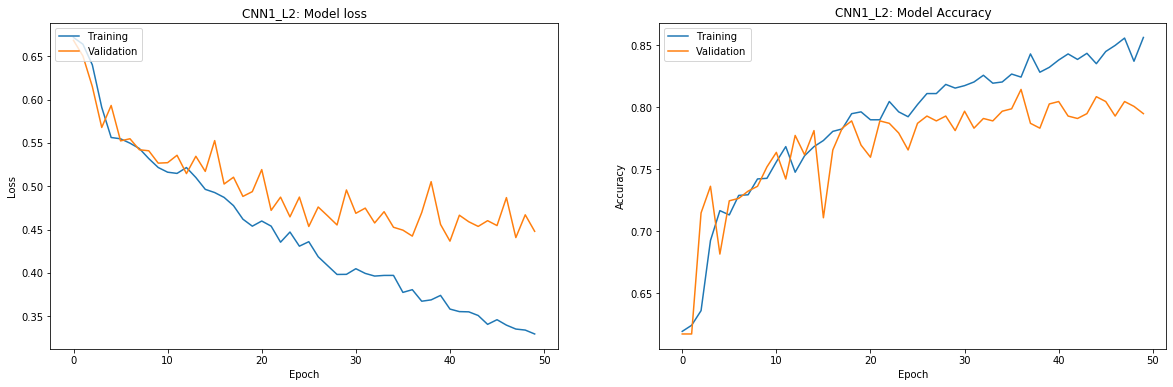

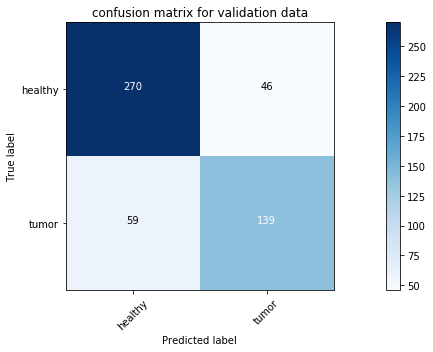


classification report for validation data:
              precision    recall  f1-score   support

           0      0.821     0.854     0.837       316
           1      0.751     0.702     0.726       198

    accuracy                          0.796       514
   macro avg      0.786     0.778     0.782       514
weighted avg      0.794     0.796     0.794       514



In [17]:
CNN1_L2.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(lr=0.001),
                metrics=['accuracy'])

history = CNN1_L2.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=n_epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=2)

plot_history(history, 'CNN1_L2')

valid_evaluate(CNN1_L2)

## Did L2 regularisation help?
When I ran these model I got a `weighted avg f1 score` of 0.803 without regularization (CNN1) and 0.794 with regularization (CNN1_aug). So not much help in this case. Again, however, see the `Final note` section at the end of this notebook.

## Final evaluation on test data
As we used the validation data to determine the best CNN architecture, we need to perform a final evaluation on test data (i.e. held-out data that the model has not yet seen). In the parenthesis below place replace ??? with the name of your model that performed best on the validation data. On this test data I got a weighted average f1-score of 0.841 with my best model. Did you manage to beat me? :)  

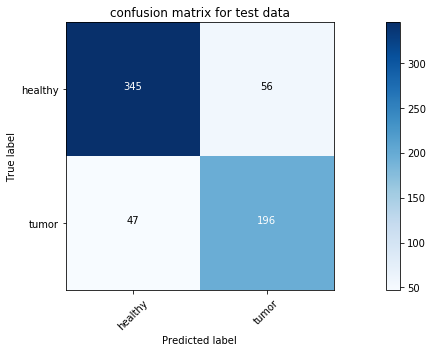


classification report for test data:
              precision    recall  f1-score   support

           0      0.880     0.860     0.870       401
           1      0.778     0.807     0.792       243

    accuracy                          0.840       644
   macro avg      0.829     0.833     0.831       644
weighted avg      0.841     0.840     0.841       644



In [18]:
test_evaluate(CNN2)

## Final notes
Due to stochasticity in how the models are defined, you may have not hit on the best model. You can run the same neural network model and get different results. We will acommodate for this issue during the assignment tomorrow. Ideally, when one has time, one would run the same model several times and take the average results. 

Combing the approaches we used (i.e. using regularization of the weights and data augmentation) on your best model from above (if it wasn't CNN1) might give a better model still. We also have some inbalance in the class weights, accomodating for this when you fit the models can also help.

Also, as yesterday, with a different train/validation/test split we can get different results - we can combat this with cross-validation.

Training neural networks is an exploratory process. In some cases - for some datasets - adding certain things (such as additional layers, data augmentation, weight regularization etc.) can help a lot. In other cases the improvements may be marginal or may even degrade the results. There aren't a lot of hard and fast rules in this field (currently) so exploaration is the name of the game. Having a large arsenal of things to try is nevertheless very useful!

Finally, we simplified the problem above by mixing up the cells, such that cells from the same individual could be in all the splits of the data. As said above, it would have been more rigerous for us to have it such that all the cells from an individual could only appear in one of the splits.